# Letters

## Description

Generate an image with the edges of the letters present in this noisy image


## Group ID

João Braga, pg????
Rafael Correia, pg54162
Robert Szabo, pg54194

In [25]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

In [26]:
def scale_image(image, N):
    # Check if the image is grayscale
    if len(image.shape) == 2:
        height, width = image.shape
        # Create a new larger image
        scaled_image = cv2.resize(image, (width * N, height * N), interpolation=cv2.INTER_LINEAR)
        return scaled_image
    else:
        print("Input image must be grayscale")

(400, 600)


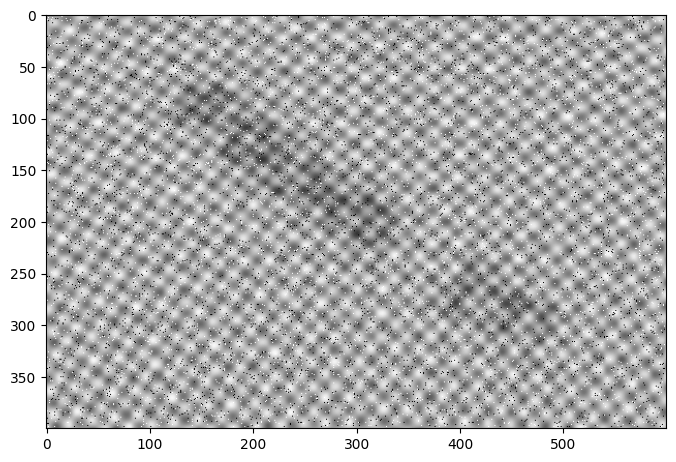

In [27]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
# histogram
hist = cv2.calcHist([img],[0],None,[256],[0,256])
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

Carregamos a imagem e vimos como o espetro era

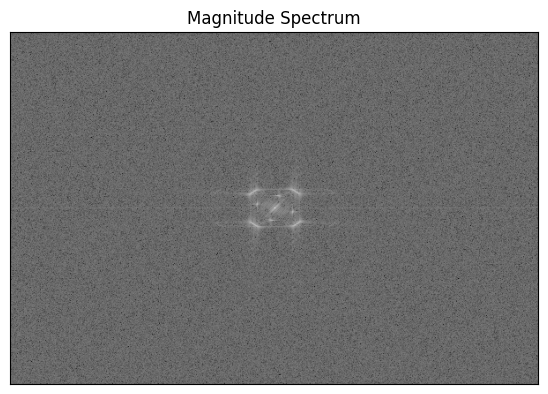

In [28]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
img_float32 = np.float32(img)
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
magnitude_spectrum = 20*np.log(magnitude_spectrum)

fig = plt.figure(figsize=(15,5))
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()   

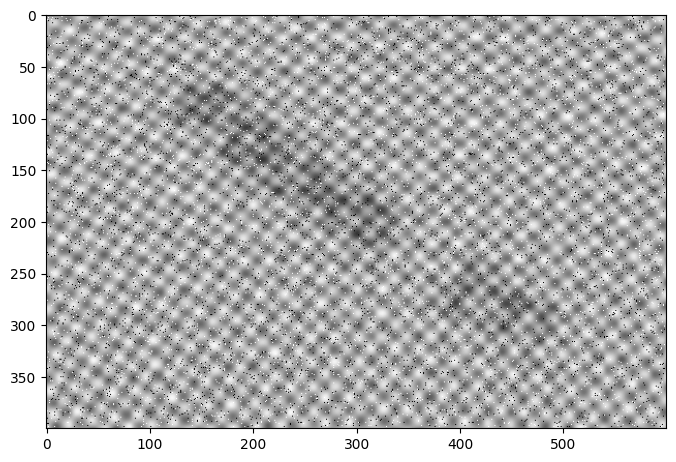

In [29]:
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

In [30]:
# manually filter high frequencies using our own ILPF
rows, cols = img.shape
crow, ccol = rows//2 , cols//2     # center

# create a mask first, center square is 1, remaining all zeros
ILPF_mask = np.zeros((rows, cols, 2), np.uint8)
# filter width and heigth
divider = 31
frows = rows//divider
fcols = cols//divider
ILPF_mask[crow-frows:crow+frows, ccol-fcols:ccol+fcols] = (1,1)
#ILPF_mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
dft_masked = dft_shift*ILPF_mask
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])


In [31]:
# manually filter high frequencies using our own ILPF
rows, cols = img.shape
crow, ccol = rows//2 , cols//2     # center

# create a mask first, center square is 0, remaining all ones
IHPF_mask = np.ones((rows, cols, 2), np.uint8)
# build from ILPF_mask
IHPF_mask = ILPF_mask

# apply mask and inverse DFT
dft_masked = dft_shift*IHPF_mask
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [32]:
# compute the frequency spectrum of the MASKED_DFT, 
# just for display purposes
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_masked[:,:,0],dft_masked[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(IHPF_mask[:,:,0],2)+np.power(IHPF_mask[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

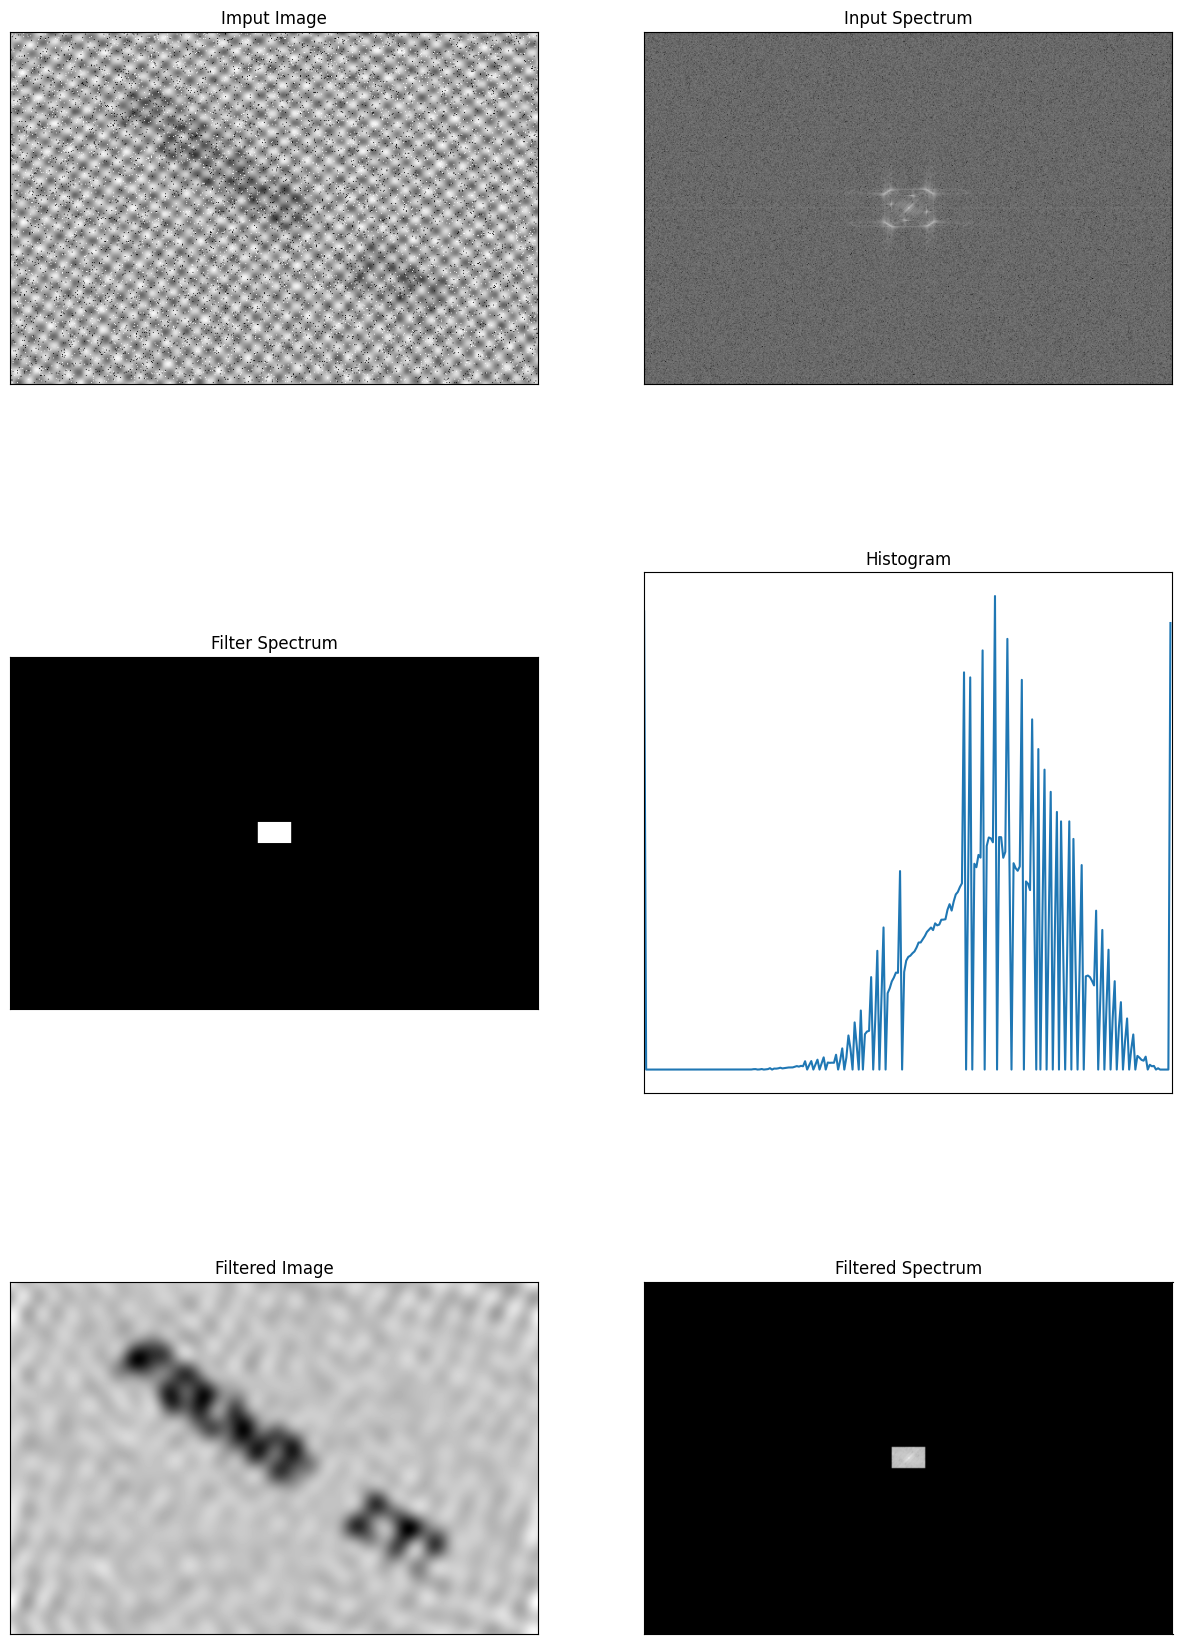

In [33]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Imput Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(324),plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(scale_image(filtered_spectrum,4), cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

In [34]:
def correlate (kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out

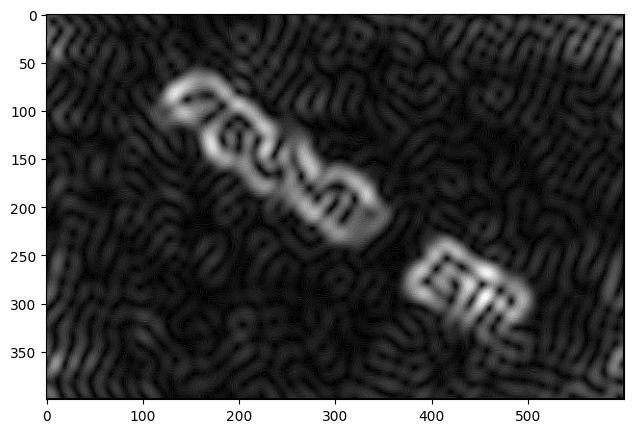

In [40]:
Sobel_y = np.array([[-1,0,1], [-2, 0, 2],[-1,0,1]], dtype=float)
Sobel_x = np.array([[-1,-2,-1], [0, 0, 0],[1,2,1]], dtype=float)
img_back=cv2.normalize(img_back, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
gx = correlate(Sobel_x, img_back)
gx = np.absolute(gx)
gy = correlate(Sobel_y, img_back)
gy = np.absolute(gy)
grad = np.sqrt(np.square(gx) + np.square(gy))
fig = plt.figure(figsize=(15,5))
plt.imshow(grad, cmap='gray')

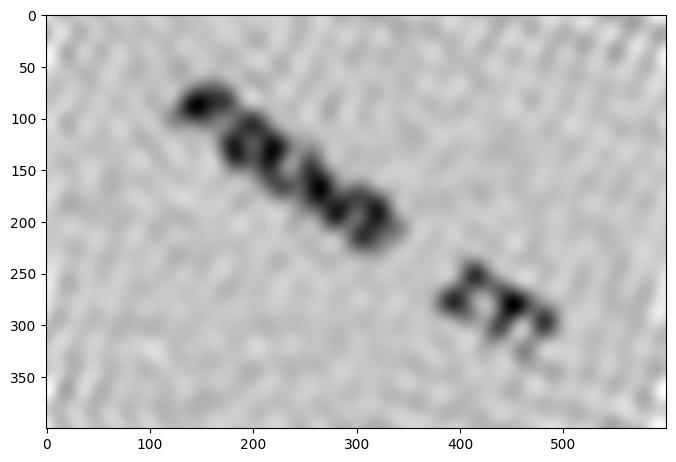

In [68]:
# OpenCV Local Denoising Filter 
h=7
ts=7
denoised_image = cv2.fastNlMeansDenoising(cv2.normalize(img_back, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U),None,h,h,ts)
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(denoised_image, cmap='gray')

hist = cv2.calcHist([denoised_image],[0],None,[256],[0,256])


plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([]), plt.yticks([])

# Normalize pixel values to range [0, 255]
#normalized_image = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Create a mask for values within the desired range
#mask = cv2.inRange(normalized_image, 0, 255)

# Apply the mask to the normalized image
#masked_image = cv2.bitwise_and(normalized_image, normalized_image, mask=mask)

# Perform histogram equalization on the masked image
img = cv2.equalizeHist(denoised_image)

hist = cv2.calcHist([cv2.normalize(denoised_image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)],[0],None,[256],[0,256])

plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([]), plt.yticks([])

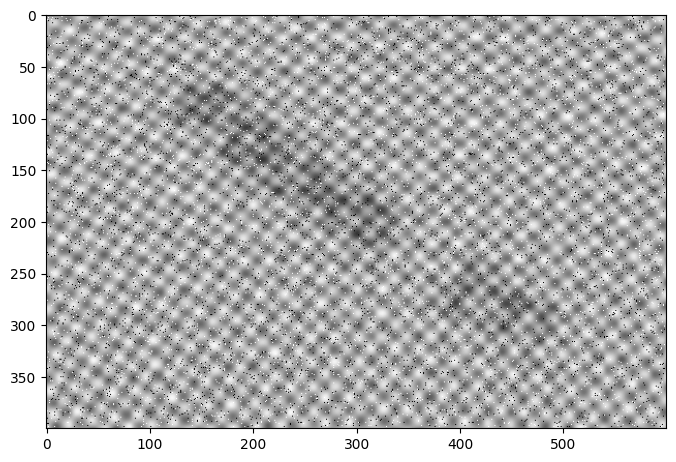

In [37]:
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

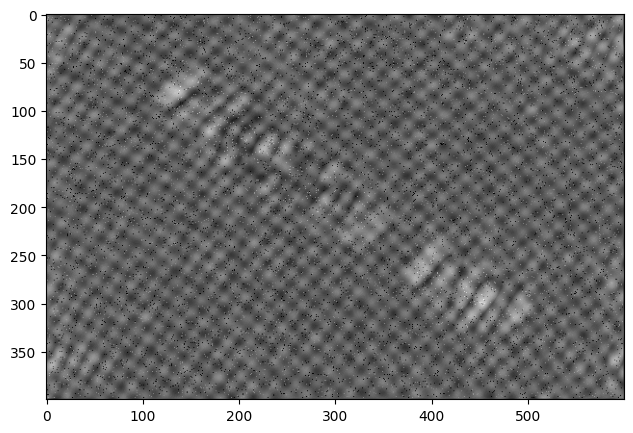

In [38]:
# correlate
def correlate (kernel, image):
    W = image.shape[0]
    H = image.shape[1]
    out =np.zeros((W,H))
    a = kernel.shape[0]%2
    b = kernel.shape[1]%2
    #print (a,b)
    for y in range(b,H-b): 
        for x in range(a,W-a): 
            for s in range (-a,a+1):
                for t in range (-b, b+1):
                    out[x,y] += (kernel[s,t]*image[x+s,y+t])
    return out


def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    for y in range(H): 
        for x in range(W): 
            image[x,y] = (image[x,y]-mymin)*256/(mymax-mymin)
    return image

Laplace = np.array([[-1,-1,-1], [-1, 8, -1],[-1,-1,-1]], dtype=float)
#print(Laplace)

dImg = correlate (Laplace, cv2.normalize(denoised_image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U))
dImg = rescale (dImg)

# sharpen edges
eImg = 0.5*dImg + 0.5*img

fig = plt.figure(figsize=(15,5))
plt.imshow(eImg, cmap='gray')

(Text(0.5, 1.0, 'Adaptive Thresholding'), ([], []), ([], []))

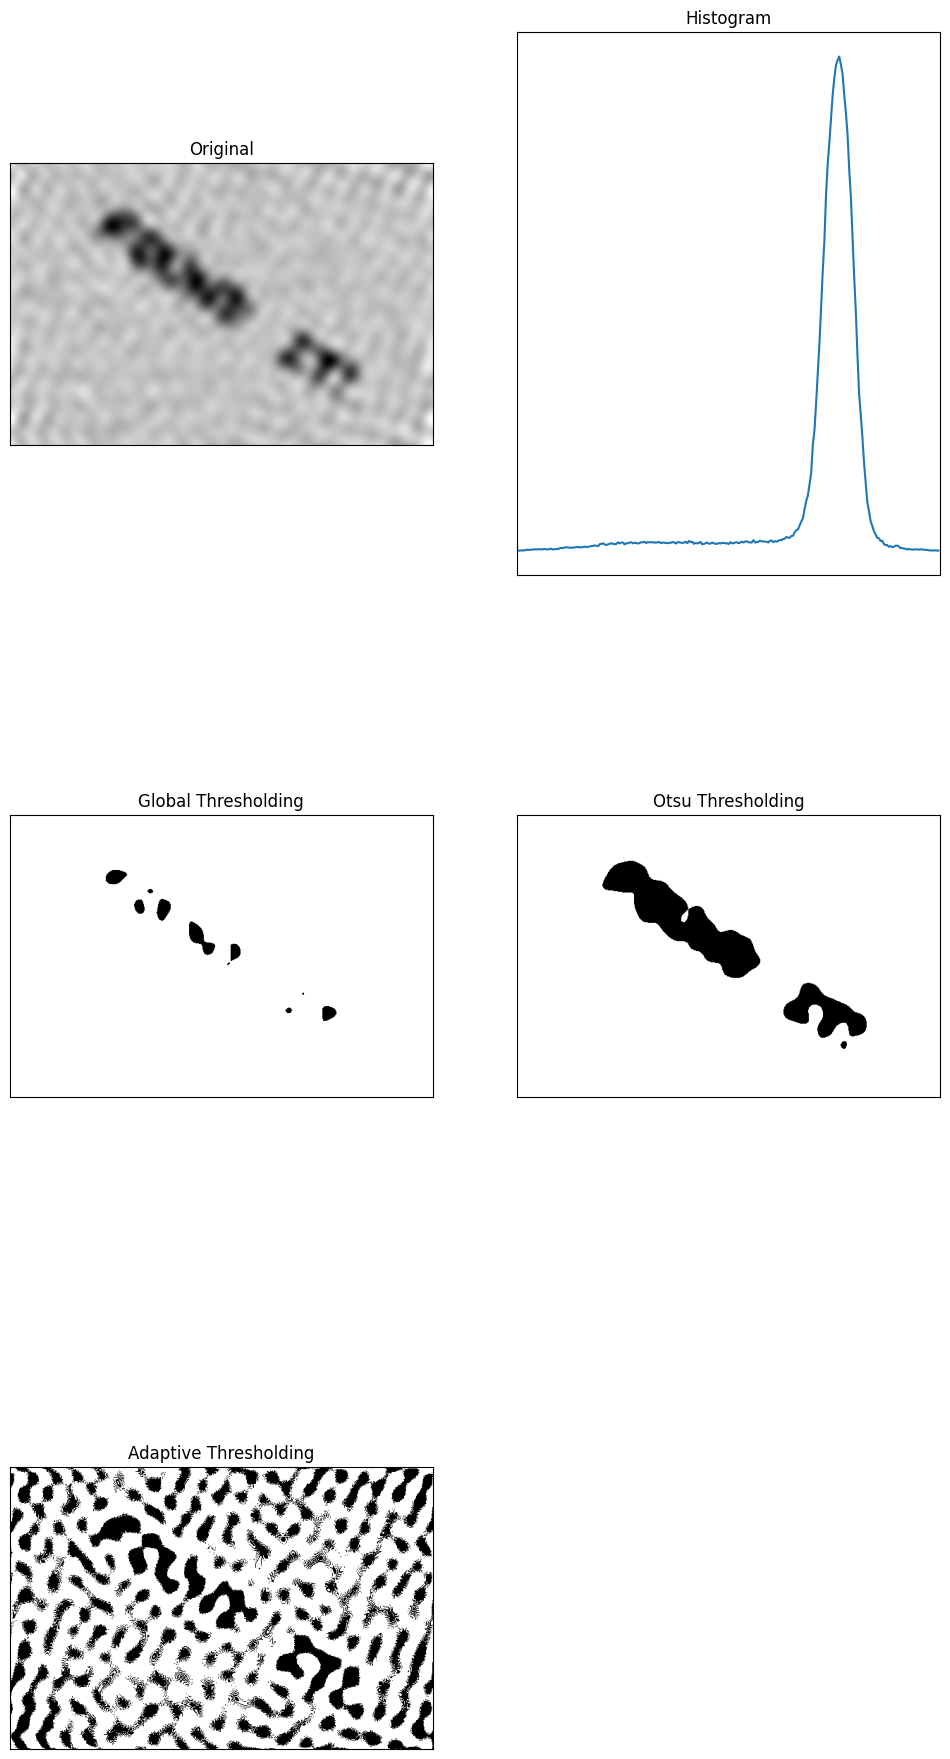

In [39]:
th_img = cv2.normalize(denoised_image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

# histogram
hist = cv2.calcHist([th_img],[0],None,[256],[0,256])

# Global
ret, Gthres = cv2.threshold(th_img,50,255,cv2.THRESH_BINARY)

# Otsu thresholding
ret, Othres = cv2.threshold(th_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Adaptive Thresholdinh
Athres = cv2.adaptiveThreshold(th_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,1)

fig = plt.figure(figsize=(12,24))
plt.subplot(3,2,1),plt.imshow(th_img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2),plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(Gthres,cmap = 'gray')
plt.title('Global Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(Othres,cmap = 'gray')
plt.title('Otsu Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,5),plt.imshow(Athres,cmap = 'gray')
plt.title('Adaptive Thresholding'), plt.xticks([]), plt.yticks([])